In [ ]:
!pip install tensorflow
!pip install tensorflow_probability
!pip install git+https://github.com/henrysky/astroNN.git

  Cloning https://github.com/henrysky/astroNN.git to /tmp/pip-req-build-epe8fgl5
  Running command git clone --filter=blob:none --quiet https://github.com/henrysky/astroNN.git /tmp/pip-req-build-epe8fgl5
  Resolved https://github.com/henrysky/astroNN.git to commit 294dd6775550adc9aaece7355b72d3b2f1d9ed8f
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from astroNN.models import Galaxy10CNN
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras import optimizers

In [ ]:
##Descarga de datos

images, labels = load_galaxy10sdss()

# To convert the labels to categorical 10 classes

labels = utils.to_categorical(labels, 10)

# Select 10 of the images to inspect

img = None
plt.ion()

# print('===================Data Inspection===================')

# for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
#     img = plt.imshow(images[i])
#     plt.title('Class {}: {} \n Random Demo images {} of 10'.format(np.argmax(labels[i]), galaxy10cls_lookup(labels[i]), counter+1))
#     plt.draw()
#     plt.pause(2.)
#     plt.close('all')

# print('===============Data Inspection Finished===============')

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [ ]:
images.shape

(21785, 69, 69, 3)

In [ ]:
images=images/255

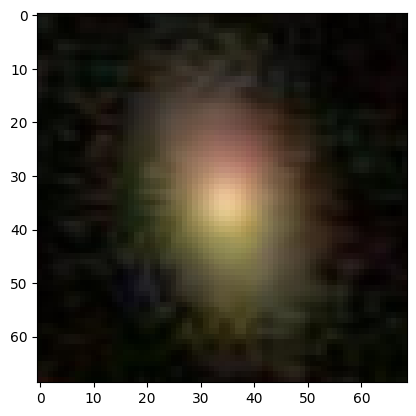

In [ ]:
plt.imshow(images[0])

In [ ]:
images.shape

(21785, 69, 69, 3)

Esto nos dice la frecuencia de cada clase

In [ ]:
np.histogram(labels.argmax(axis=1))[0]


array([3461, 6997, 6292,  349, 1534,   17,  589, 1121,  906,  519])

In [ ]:
##Preparacion de los datos

# To convert to desirable type

labels = labels.astype(np.float32)
images = images.astype(np.float32)

# Split the dataset into a learning set and testing set

learn_idx, test_idx = train_test_split(np.arange(labels.shape[0]), train_size=0.8, test_size=0.2)
learn_images, learn_labels, test_images, test_labels = images[learn_idx], labels[learn_idx], images[test_idx], labels[test_idx]

# #Now, split learning dataset into a Training dataset and a validation dataset
# train_idx, val_idx = train_test_split(np.arange(learn_labels.shape[0]), train_size=0.7, test_size=0.3)
# train_images, train_labels, val_images, val_labels =img_B[train_idx], labels[train_idx], img_B[val_idx], labels[val_idx]

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
# ##Definicion del modelo

# model = models.Sequential([
#     layers.Conv2D(128, (3, 3), activation='relu', input_shape=(69, 69,3), kernel_regularizer=regularizers.l2(0.001)),
#     #layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((3, 3)),
#     layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
#     layers.Flatten(),
#     layers.Dense(120, activation='tanh', kernel_regularizer=regularizers.l2(0.001) ),
#     layers.Dropout(0.2),
#     layers.Dense(80, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.2),
#     # layers.Dense(60, activation='tanh'),
#     # layers.Dropout(0.3),
#     # layers.Dense(60, activation='tanh'),
#     # layers.Dropout(0.3),
#     layers.Dense(10, activation='softmax')
# ])

# model.summary()



In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(69, 69, 3), kernel_regularizer=regularizers.l2(0.001)),
    #layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(150, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(60, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       2

Vemos la frecuencia para el conjunto de entrenamiento, no es muy diferente del histograma original para las clases de baja frecuencia...

In [ ]:
np.histogram(learn_labels.argmax(axis=1))[0]

array([2773, 5575, 5033,  294, 1223,   13,  467,  899,  739,  412])

In [ ]:
##Copilacion del modelo
lr = 0.001  # Learning rate
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
optimizer=optimizers.Adam(learning_rate=lr))

# lr = 0.001  # Learning rate
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
# optimizer=optimizers.SGD(learning_rate=lr))

# model.compile(optimizer='Adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:

#Entrenamiento del modelo
history=model.fit(learn_images, learn_labels, validation_split=0.3,epochs=60, batch_size=64)

Epoch 1/60
191/191 [==============================] - 24s 58ms/step - loss: 1.8356 - accuracy: 0.3677 - val_loss: 1.5058 - val_accuracy: 0.4443
Epoch 2/60
191/191 [==============================] - 10s 50ms/step - loss: 1.4975 - accuracy: 0.4511 - val_loss: 1.3668 - val_accuracy: 0.5100
Epoch 3/60
191/191 [==============================] - 10s 50ms/step - loss: 1.3702 - accuracy: 0.5028 - val_loss: 1.2363 - val_accuracy: 0.5628
Epoch 4/60
191/191 [==============================] - 10s 51ms/step - loss: 1.2920 - accuracy: 0.5440 - val_loss: 1.2598 - val_accuracy: 0.5339
Epoch 5/60
191/191 [==============================] - 10s 50ms/step - loss: 1.2053 - accuracy: 0.5946 - val_loss: 1.0677 - val_accuracy: 0.6569
Epoch 6/60
191/191 [==============================] - 9s 49ms/step - loss: 1.1063 - accuracy: 0.6499 - val_loss: 1.0377 - val_accuracy: 0.6714
Epoch 7/60
191/191 [==============================] - 9s 49ms/step - loss: 1.0621 - accuracy: 0.6765 - val_loss: 1.0116 - val_accuracy: 0

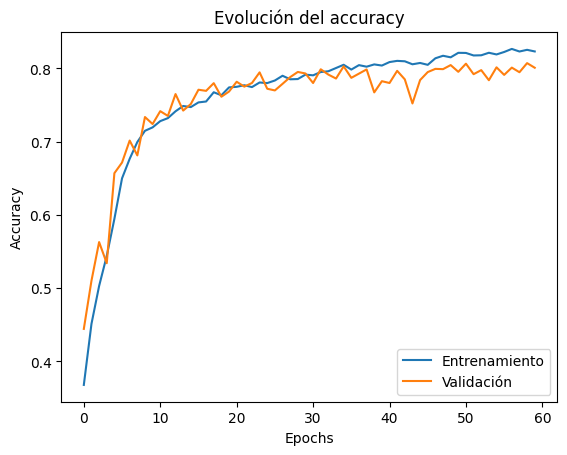

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_validation = history.history['val_accuracy']

# Grafica la evolución del accuracy
plt.plot(accuracy_train, label='Entrenamiento')
plt.plot(accuracy_validation, label='Validación')
plt.title('Evolución del accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

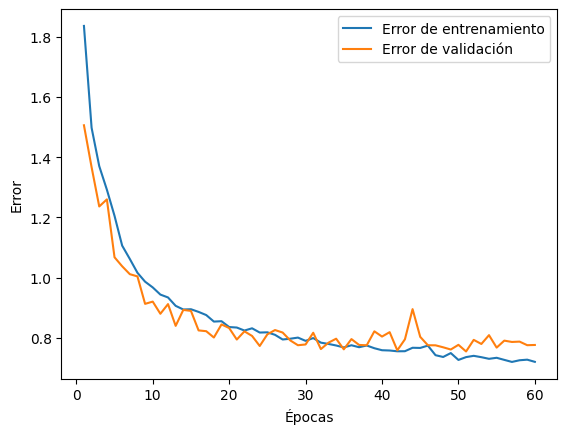

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Graficamos el error
plt.plot(epochs, train_loss, label='Error de entrenamiento')
plt.plot(epochs, val_loss, label='Error de validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
#evaluacion del modelo
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

137/137 [==============================] - 1s 9ms/step - loss: 0.7460 - accuracy: 0.8141


In [ ]:
model.save("pfinal")

In [ ]:
model.evaluate(images, labels)

681/681 [==============================] - 7s 11ms/step - loss: 0.6571 - accuracy: 0.8515


[0.657062292098999, 0.8515492081642151]

In [ ]:
import seaborn as cns
from sklearn.metrics import confusion_matrix
import sklearn.metrics

In [ ]:
def plot_cm(Y_reales,Y_predichos, labels, porcentaje=False):
    #Generamos la matriz de confusión a partir de los dos arreglos
    matrix = sklearn.metrics.confusion_matrix(Y_reales.argmax(axis=1), Y_predichos.argmax(axis=1))

    plt.title("Confusion matrix")
    #Aquí se divie si la queremos en porcentaje o en números
    if porcentaje==False: ax = cns.heatmap(matrix, annot=True, cmap="viridis", cbar_kws={'label': 'scale'})
    if porcentaje==True:
        m=np.zeros(matrix.shape)
        for j in range(0,matrix.shape[1]):
            m[:,j]=matrix[:,j]/np.sum(matrix[:,j])
        ax = cns.heatmap(m, annot=True,fmt='.2%',
                                          cmap='viridis', cbar_kws={'label': 'scale'})

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(xlabel="True label", ylabel="Predicted label")

137/137 [==============================] - 1s 7ms/step


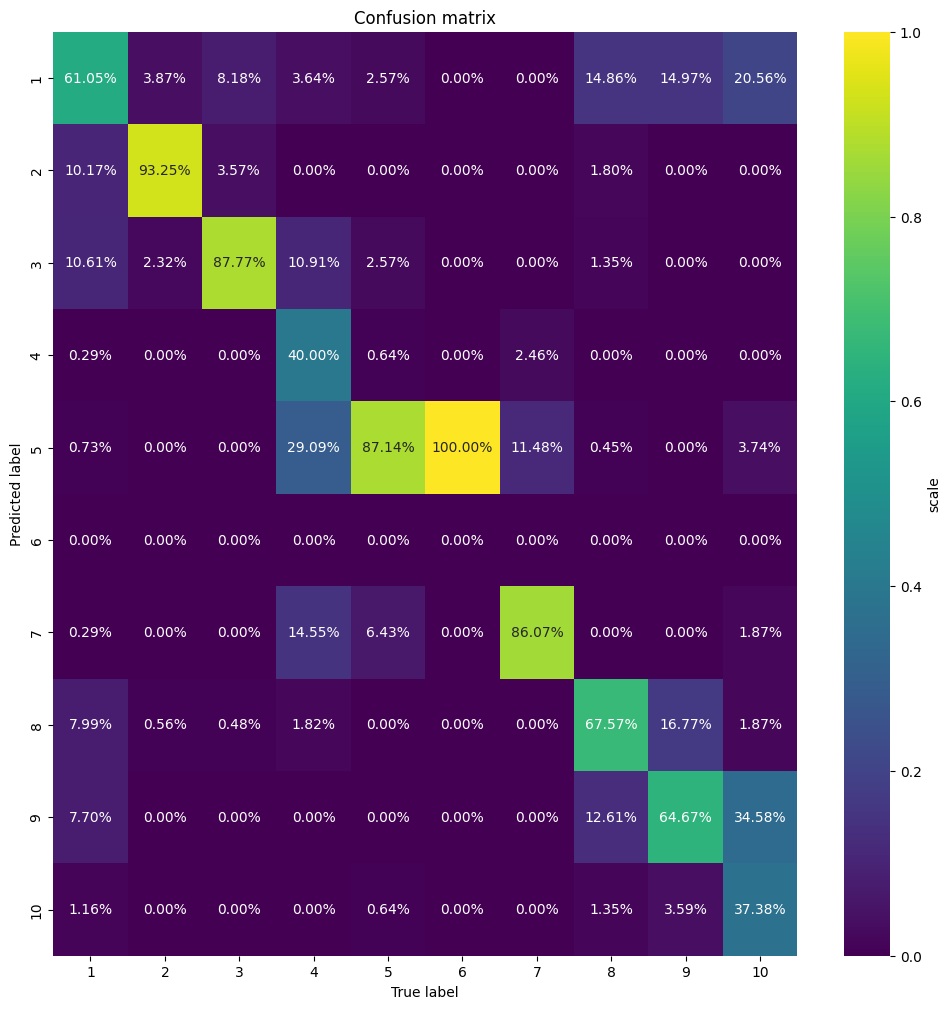

In [ ]:
#y_test=model.predict(data)
plt.figure(figsize=(12,12))
labels=['1','2', '3', '4', '5', '6', '7', '8', '9', '10']
plot_cm(model.predict(test_images),test_labels, labels, porcentaje=True)
#plt.savefig('matriz_conf_galaxias.pdf')

In [ ]:
model.save('galaxias_Modelado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
model.save('galaxias_Joel')

In [ ]:
!zip -r /content/file.zip /content/pfinal

  adding: content/pfinal/ (stored 0%)
  adding: content/pfinal/saved_model.pb (deflated 89%)
  adding: content/pfinal/keras_metadata.pb (deflated 93%)
  adding: content/pfinal/variables/ (stored 0%)
  adding: content/pfinal/variables/variables.index (deflated 65%)
  adding: content/pfinal/variables/variables.data-00000-of-00001 (deflated 26%)
  adding: content/pfinal/fingerprint.pb (stored 0%)
  adding: content/pfinal/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>